<a href="https://colab.research.google.com/github/sipocz/Colab/blob/main/AIT4_Vizsgafeladat_20210422_Sipocz_Laszlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install sktime

# **Feladat kiírás: Idősor elemzése**
Az ipari gyakorlatot az időben változó paraméterek jellemzik. Ezen paraméterek figyelése, elemzése pénzben is kifejezhető eredményt produkálhat. Egy ilyen feladat megoldására vállalkoznék az első javaslatomban:

Rendelkezésre áll egy ipari terület nitrogén fogyasztásával kapcsolatos adathalmaz. Az adatok egy Internetes felületről érhetők el. A megoldással kapcsolatos elvárások:
1. Az internetes felületről adatok letöltése (webscaping) technikával.
2. Az adatok feldolgozása, CSV-ben történő tárolása
3. Az adatok elemzése ahol a következő kérdésekre keressük a válaszokat:
    * Az adatok alapján jelezhetünk-e valamilyen kiugró értéket, 
valamilyen hibát, ami alapján emberi beavatkozási igény is felmerül.
    * Az adatok alapján történik-e valamilyen tendenciózus jelenség:
    * Emelkedő fogyasztás
    * Nem szokványos nyomás emelkedés, csökkenés ami a korábbi tapasztalatokból nem látszik. 
    * Lengés megjelenése a rendszerben
4. Felismerhető-e valamilyen összefüggés az adatokban, amivel az esetlegesen hiányzó adat  pótolható, becsülhető. (Soft Sensor)


# Az adatok bemutatása

[Adatforrás](http://telemetry.messer.hu:8080/cgi-bin/rview.exe?Name=Richter1&Password=Messer2&Server=10.24.17.2&Language=hu)

[Egy nap adata: -04-04-](http://telemetry.messer.hu:8080/cgi-bin/rview.exe?Log=..%5C..%5Cppsrv%5CRichter1.txt&Html=Richter1log&MaxRows=15000&Year1=2021&Mon1=4&Day1=4&Hour1=0&Year2=2021&Mon2=4&Day2=4&Hour2=23)

Az adatok elérésehéz webscaping technikát használtam. A következő fejezet erről szól.

In [3]:
import requests
import pandas as pd
import time
import datetime

from bs4 import BeautifulSoup

def i2str(i):
    i2=str(i)
    if len(i2)<2:
        i2="0"+i2
    return(i2)

confline=   {
            "path":"./",
            "prefix":"Nitrogen"
            }

if "path" in confline:
    path=confline["path"]
if "prefix" in confline:
    prefix=confline["prefix"]

#print(path+prefix)

def getdata(t1,t2):
    #print(t1)
    #print(t2)
    y1=i2str(t1.year)
    m1=i2str(t1.month)
    d1=i2str(t1.day)


    y2=i2str(t2.year)
    m2=i2str(t2.month)
    d2=i2str(t2.day)

    url1="http://telemetry.messer.hu:8080/cgi-bin/rview.exe?Log=..%5C..%5C..%5Cppsrv%5CRichter1.txt&Html=Richter1log&MaxRows="
    url2="10000&Year1="+y1+"&Mon1="+m1+"&Day1="+d1+"&Hour1=0&Year2="+y2+"&Mon2="+m2+"&Day2="+d2+"&Hour2=0"

    url=url1+url2

    fname=path+prefix+y1+m1+d1+".csv"
    result=requests.get(url)
    soup = BeautifulSoup(result.content, 'html.parser')
    allrow=soup.find_all("tr")[:]
    fo  = open(fname, "w",encoding='utf-8')
    for  row in allrow:
        soup2=BeautifulSoup(result.content, 'html.parser')
        allcell=row.find_all("td")[:]
        sumcell=""
        #print("--------------")
        #print(allcell)
        for cell in allcell:
            celltxt=cell.text
            sumcell=sumcell+celltxt+";"

        outstr=sumcell.replace(".",",").replace(";"," ",1).replace(",",".",2).replace("   ","").replace("  ","")
        #print(outstr)

        fo.write(outstr+"\n")

    # Close file
    fo.close()
    return(fname)

In [4]:
t1=datetime.date.today() # !! ez a dátum a serveren értelmezett mai dátum 
print(t1)    #a mai nap
backtime=datetime.timedelta(days=1) # itt kezdi a letöltést ennyi nappal azelőtt nekünk most 1 nap kell a tegnapi nap megvan teljesen!
#egy napnyi adatot akarunk lekérdezni
tk=t1-backtime # a tegnapi nap lesz a kezdeti nap
dt=datetime.timedelta(days=1) # olyen időközökben kérünk új adatsort!

for i in range(1):  # ennyi napnyi adatot tölt le!! t1 -től kezdődően  Nekünk most csak egy kell! 
    t2=tk+dt
    fname=getdata(tk,t2)
    tk=t2


2021-04-11


**5 perces mintavétellel érkeznek az adatok**

In [5]:
import pandas as pd
df=pd.read_csv(fname, sep=";", decimal=",",)
df.drop(columns=["Unnamed: 6"],inplace = True)
print(df.head(5))
print(df.tail(5))
df.describe()

             Dátum Idõ  ...  PSA minőség: [%]
0  2021.04.10 00:04:36  ...            0.1889
1  2021.04.10 00:09:36  ...            0.1862
2  2021.04.10 00:14:36  ...            0.1809
3  2021.04.10 00:19:36  ...            0.1755
4  2021.04.10 00:24:36  ...            0.1706

[5 rows x 6 columns]
               Dátum Idõ  ...  PSA minőség: [%]
282  2021.04.10 23:37:23  ...            0.0623
283  2021.04.10 23:42:23  ...            0.0623
284  2021.04.10 23:47:23  ...            0.0623
285  2021.04.10 23:52:23  ...            0.0619
286  2021.04.10 23:57:23  ...            0.0619

[5 rows x 6 columns]


,LIN tartály menny.: [m3],LIN tartály nyomás: [barg],PSA mennyiség: [m3],PSA nyomás: [barg],PSA minőség: [%]
count,287.000000,287.000000,287.000000,287.000000,287.000000
mean,28219.132404,8.806132,392.156098,8.364808,0.096847
std,33.337277,0.173490,120.174575,0.132678,0.034971
min,28147.000000,8.490000,0.000000,8.000000,0.058600
25%,28198.500000,8.660000,327.650000,8.200000,0.066600
50%,28210.000000,8.820000,418.400000,8.400000,0.081600
75%,28248.500000,8.960000,483.600000,8.500000,0.126800
max,28314.000000,9.080000,579.300000,8.600000,0.188900


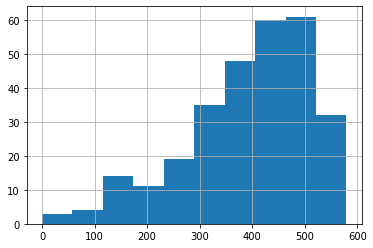

In [6]:
df["PSA mennyiség: [m3]"].hist();

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting import plot_series

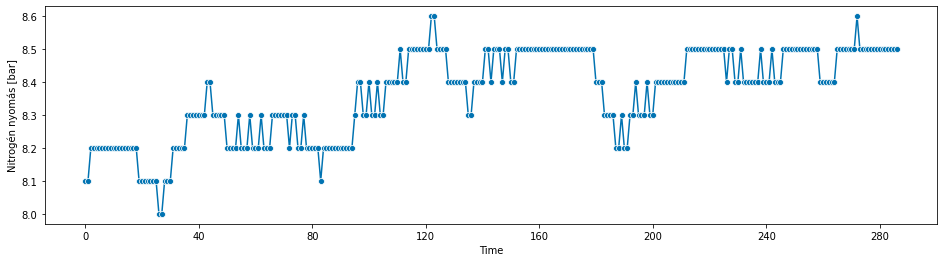

In [112]:
y = df["PSA nyomás: [barg]"]

fig, ax = plot_series(y)
ax.set(xlabel="Time", ylabel="Nitrogén nyomás [bar]");

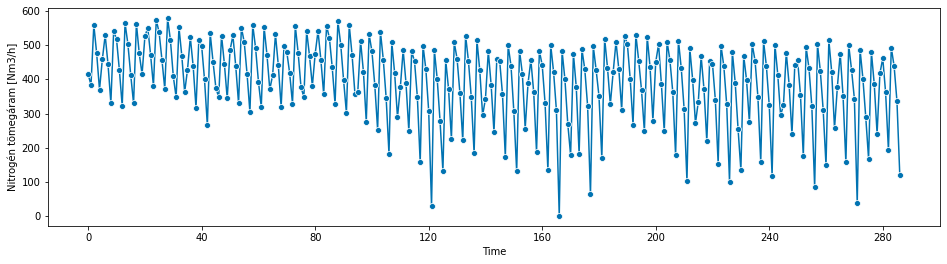

In [113]:

y = df["PSA mennyiség: [m3]"]
fig, ax = plot_series(y)
ax.set(xlabel="Time", ylabel="Nitrogén tömegáram [Nm3/h]");


# Éves adathalmaz előállítása
A napi adatokat egy python script (mi más? :-) ) összefűzi egy teljes adatsorrá! A dátumformátumot is helyrerakja. Így később nem lesz vele dolgunk. A fejlécek értelmesebb (és rövidebb) elnevezést kapnak: 


---


[konverter program:](https://github.com/sipocz/messer/blob/b65c35a08bed9565d9df9ed6be1f1e94c53b004d/messer_convert.py)


## Adatok letöltése

Az adatok előfeldolgozása, előkészítése megtörtént. Az internetes elérés céljából github repoban vannak. 

In [115]:

!rm /content/all.csv
!wget "https://github.com/sipocz/messer/raw/main/all.csv"
!head /content/all.csv

rm: cannot remove '/content/all.csv': No such file or directory
--2021-04-11 19:48:39--  https://github.com/sipocz/messer/raw/main/all.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sipocz/messer/main/all.csv [following]
--2021-04-11 19:48:39--  https://raw.githubusercontent.com/sipocz/messer/main/all.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6249032 (6.0M) [text/plain]
Saving to: ‘all.csv’

all.csv             100%[===================>]   5.96M  16.1MB/s    in 0.4s    

2021-04-11 19:48:40 (16.1 MB/s) - ‘all.csv’ saved [6249032/6249032]

timeStamp,LIN_V,LIN_P,PSA_M,PSA_P,PSA_Q
20

In [118]:
# Az univerzalitás érdekében itt lehet konfigurálni, hogy hol található a működéshez szükséges fájl 

_PCVERSION_=False
_GITHUB_ORIG=True

if _PCVERSION_:
    basedir="C:/Users/sipocz/OneDrive/Dokumentumok/GitHub/nitrogen"
else:

    if _GITHUB_ORIG:
        basedir="/content/"
    else:
        from google.colab import drive
        drive.mount('/content/drive',force_remount=True)
        basedir="/content/drive/My Drive/001_AI/messer/nitrogen/"
print(f"Az alapkönyvtár: {basedir}")  


Az alapkönyvtár: /content/


## Olvassuk be az adathalmazt, vizsgáljuk!!

In [122]:
df=pd.read_csv(basedir+"all.csv")
print(df.head())
print("\n")
print(f"timeStamp adattípus: {type(df.timeStamp[0])}")


             timeStamp     LIN_V  LIN_P  PSA_M  PSA_P   PSA_Q
0  2019-11-21 09:58:15  32356.38   9.00  626.1    7.6  0.2749
1  2019-11-21 10:03:16  32346.85   9.00  663.1    7.7  0.2761
2  2019-11-21 10:03:21  32347.00   8.59  663.1    7.7  0.2761
3  2019-11-21 10:08:22  32350.00   8.61  548.9    7.7  0.2737
4  2019-11-21 10:13:21  32327.00   8.62  492.5    7.7  0.2694


timeStamp adattípus: <class 'str'>


## Az időbélyeget át kell konvertálni dátum formátumra! Ennek még később meglesz a haszna!

In [123]:
df["timeStamp"]=pd.to_datetime(df["timeStamp"],format="%Y.%m.%d %H:%M:%S")   # konvertáljuk az időbélyeget


d=df[["timeStamp","PSA_M"]]
d.set_index("timeStamp",inplace=True)

## Ellenőrizzük vissza!

In [124]:
print(df.head())
print("\n")
print(f"timeStamp adattípus: {type(df.timeStamp[0])}")

            timeStamp     LIN_V  LIN_P  PSA_M  PSA_P   PSA_Q
0 2019-11-21 09:58:15  32356.38   9.00  626.1    7.6  0.2749
1 2019-11-21 10:03:16  32346.85   9.00  663.1    7.7  0.2761
2 2019-11-21 10:03:21  32347.00   8.59  663.1    7.7  0.2761
3 2019-11-21 10:08:22  32350.00   8.61  548.9    7.7  0.2737
4 2019-11-21 10:13:21  32327.00   8.62  492.5    7.7  0.2694


timeStamp adattípus: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


## Nézzünk egy statisztikát az adatokról!

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122423 entries, 0 to 122422
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timeStamp  122423 non-null  datetime64[ns]
 1   LIN_V      122423 non-null  float64       
 2   LIN_P      122423 non-null  float64       
 3   PSA_M      122423 non-null  float64       
 4   PSA_P      122423 non-null  float64       
 5   PSA_Q      122423 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 5.6 MB


In [132]:
print(f"{df.isnull().sum()} \ndarab  NAN van a DF-ben" )

timeStamp    0
LIN_V        0
LIN_P        0
PSA_M        0
PSA_P        0
PSA_Q        0
dtype: int64 
darab  NAN van a DF-ben


In [126]:
df.describe()

,LIN_V,LIN_P,PSA_M,PSA_P,PSA_Q
count,122423.000000,122423.000000,1.224230e+05,1.224230e+05,122423.000000
mean,28433.207824,8.821156,4.737695e+13,-2.536314e+14,0.264662
std,4025.686044,0.425710,8.450203e+15,1.548388e+15,0.273659
min,0.000000,0.000000,0.000000e+00,-9.707291e+15,0.000000
25%,25927.000000,8.580000,3.021000e+02,7.600000e+00,0.118200
50%,29180.000000,8.780000,4.731000e+02,7.900000e+00,0.186300
75%,31733.000000,9.000000,5.833000e+02,8.300000e+00,0.266800
max,34528.000000,11.260000,1.738199e+18,9.000000e+00,1.049100


##Vegyük észre !!
PSA_M max értéke és PSA_P min értéke nem reális adat! Valami hiba történt az adatgyűjtéssel?
Ne számoljunk ezekkel az értékekkel, ezeket meg kellene találni az adathalmazban és ki kellene gyomlálni!
Van-e az adatok között nan?

In [133]:
print(f"{df.isnull().sum()} db NAN van a DF-ben" )

timeStamp    0
LIN_V        0
LIN_P        0
PSA_M        0
PSA_P        0
PSA_Q        0
dtype: int64 db NAN van a DF-ben


NAN nincs, akkor foglalkozzunk az kiugró értékekkel! 

# ÖTLET: Hétvégi fogyasztásokat meg kellene nézni!!!